In [5]:
print(literacy.columns)
print(literacy.head())


Index(['state', 'literacy_rate'], dtype='object')
                 state  literacy_rate
0  Andaman And Nicobar            NaN
1       Andhra Pradesh            NaN
2  Arunanchal Pradesh             NaN
3               Assam             NaN
4               Bihar             NaN


In [4]:
print("demographic states:", demo_counts["state"].nunique())
print("population states:", population["state"].nunique())
print("literacy states:", literacy["state"].nunique())

print("\nexample literacy values:")
print(literacy.head(10))

print("\nstates after final merge:")
print(df["state"].nunique())
print(df["state"].head(10))


demographic states: 36
population states: 37
literacy states: 36

example literacy values:
                                  state  literacy_rate
0                   Andaman And Nicobar            NaN
1                        Andhra Pradesh            NaN
2                   Arunanchal Pradesh             NaN
3                                Assam             NaN
4                                Bihar             NaN
5                            Chandigarh            NaN
6                          Chhattisgarh            NaN
7  Dadra Nagar Haveli And Daman And Diu            NaN
8                                 Delhi            NaN
9                                   Goa            NaN

states after final merge:
0
Series([], Name: state, dtype: object)


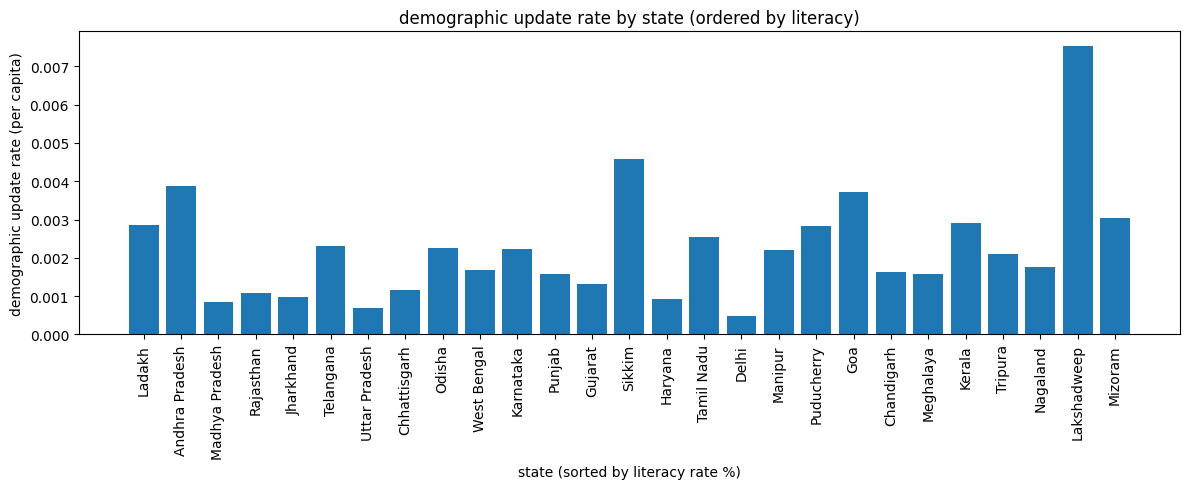

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------- demographic updates ----------------

demographic_df=pd.read_parquet("../sql/data/data_cache/demographic_clean.parquet")

demo_counts=(
    demographic_df
    .groupby("state")
    .size()
    .rename("demographic_updates")
    .reset_index()
)

# ---------------- population ----------------

population=pd.read_csv("../sql/data/Population of Indian states 2025.csv")

population=population.rename(columns={
    "State/UT":"state",
    "Population 2025":"population"
})

population["population"]=(
    population["population"]
    .astype(str)
    .str.replace(",","")
    .astype(int)
)

df=demo_counts.merge(population,on="state",how="inner")

# demographic update rate (per capita)
df["demographic_update_rate"]=df["demographic_updates"]/df["population"]

# ---------------- literacy (EXCEL, % VALUES) ----------------

literacy=pd.read_excel("../sql/data/Aadhar_literacy.xlsx")

literacy.columns=literacy.columns.str.lower().str.strip()

# detect literacy column safely
lit_col=[c for c in literacy.columns if "literacy" in c][0]

literacy=literacy.rename(columns={
    literacy.columns[0]:"state",
    lit_col:"literacy_rate"
})

# literacy values are percentages
literacy["literacy_rate"]=(
    literacy["literacy_rate"]
    .astype(str)
    .str.replace("%","")
    .str.strip()
)

literacy["literacy_rate"]=pd.to_numeric(literacy["literacy_rate"],errors="coerce")

# ---------------- merge & clean ----------------

df=df.merge(literacy,on="state",how="inner")
df=df.dropna(subset=["literacy_rate","demographic_update_rate"])

# sort by literacy (low → high)
df=df.sort_values("literacy_rate")

# ---------------- plot (BAR) ----------------

plt.figure(figsize=(12,5))
plt.bar(df["state"],df["demographic_update_rate"])
plt.xticks(rotation=90)
plt.xlabel("state (sorted by literacy rate %)")
plt.ylabel("demographic update rate (per capita)")
plt.title("demographic update rate by state (ordered by literacy)")
plt.tight_layout()
plt.show()
